In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
 
import numpy as np
import cv2
import os
import random
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
## Generators and discriminators
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """
 
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
 
        use_bias = False
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]
 
        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]
 
        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
 
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
 
        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
 
        self.model = nn.Sequential(*model)
 
    def forward(self, input):
        """Standard forward"""
        return self.model(input)
 
 
class ResnetBlock(nn.Module):
    """Define a Resnet block"""
 
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)
 
    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
 
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
 
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]
 
        return nn.Sequential(*conv_block)
 
    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""
 
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
 
 
        use_bias = False
 
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
 
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
 
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)
 
    def forward(self, input):
        """Standard forward."""
        return torch.sigmoid(self.model(input))

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
DEVICE

'cuda'

In [6]:
test_generator = ResnetGenerator(3,3).to(DEVICE)
test_image = torch.zeros((1,3,224,224)).to(DEVICE)
test_op = test_generator(test_image)
print(test_op.shape)
test_discriminator = NLayerDiscriminator(3).to(DEVICE)
test_op2 = test_discriminator(test_image)
print(test_op2.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 26, 26])


In [7]:
class Trainer:
    def __init__(self, netG_AB, netG_BA, netD_A, netD_B, lr_g=0.0005, lr_d=0.001,
                                cyc_coeff = 5, id_coeff = 1.2, load_pretrained = False):
        self.netG_AB = netG_AB
        self.netG_BA = netG_BA
        self.netD_B =  netD_B
        self.netD_A = netD_A
        self.G_opt = Adam(list(netG_AB.parameters())+list(netG_BA.parameters()), lr = lr_g)
        self.D_opt = Adam(list(netD_A.parameters())+list(netD_B.parameters()), lr = lr_d)
        self.mse = nn.MSELoss()
        self.L1Loss =  nn.L1Loss()
        self.cyc_coeff = cyc_coeff
        self.id_coeff = id_coeff
        self.step = 0
        if load_pretrained:
            self.load()

    def save(self):
        torch.save(self.netG_AB.state_dict(), "/content/gdrive/My Drive/cycle GAN/netG_AB.pth")
        torch.save(self.netG_BA.state_dict(), "/content/gdrive/My Drive/cycle GAN/netG_BA.pth")
        torch.save(self.netD_A.state_dict(), "/content/gdrive/My Drive/cycle GAN/netD_A.pth")
        torch.save(self.netD_B.state_dict(), "/content/gdrive/My Drive/cycle GAN/netD_B.pth")
        print("weight saved!!")
    
    def load(self):
        print("loading weights...")
        self.netG_AB.load_state_dict(torch.load( "/content/gdrive/My Drive/cycle GAN/netG_AB.pth"))
        self.netG_BA.load_state_dict(torch.load( "/content/gdrive/My Drive/cycle GAN/netG_BA.pth"))
        self.netD_A.load_state_dict(torch.load( "/content/gdrive/My Drive/cycle GAN/netD_A.pth"))
        self.netD_B.load_state_dict(torch.load( "/content/gdrive/My Drive/cycle GAN/netD_B.pth"))
        print("weights loaded..")

    def fit(self, dataloader, test_dataloader):
        dataloader = tqdm(dataloader)
        dataloader = enumerate(dataloader)
        gl = 0
        dl = 0
        for i, (realA, realB) in dataloader:
            fakeB = self.netG_AB(realA)
            fakeA = self.netG_BA(realB)
 
            #discriminator updation
            fakeA_probs, realA_probs = self.netD_A(fakeA.detach()), self.netD_A(realA)
            fakeB_probs, realB_probs = self.netD_B(fakeB.detach()), self.netD_B(realB)
            D_loss  = self.mse(fakeA_probs, torch.zeros_like(fakeA_probs)) + self.mse(fakeB_probs, torch.zeros_like(fakeB_probs))+ \
                        self.mse(realA_probs, torch.ones_like(realA_probs))+ self.mse(realB_probs, torch.ones_like(realB_probs)) 
            #D_loss = D_loss/2
            self.D_opt.zero_grad()
            D_loss.backward()
            self.D_opt.step()
 
            #generator updation part
            #cycle loss, adversial loss, identity loss
            fakeA_probs = self.netD_A(fakeA)
            fakeB_probs = self.netD_B(fakeB)
            G_adv_Loss = self.mse(fakeA_probs, torch.ones_like(fakeA_probs)) + self.mse(fakeB_probs, torch.ones_like(fakeB_probs))
            #G_adv_Loss /= 2
            G_cyclic_lossABA = self.L1Loss(self.netG_BA(fakeB),realA) 
            G_cyclic_lossBAB = self.L1Loss(self.netG_AB(fakeA),realB)
            G_cyclic_Loss = G_cyclic_lossABA+G_cyclic_lossBAB
            identity_Loss = self.L1Loss(self.netG_AB(realB),realB) + self.L1Loss(self.netG_BA(realA), realA)
 
            G_loss = G_adv_Loss + self.cyc_coeff*G_cyclic_Loss + self.id_coeff*identity_Loss
            self.G_opt.zero_grad()
            G_loss.backward()
            self.G_opt.step()
            gl+=G_loss.detach().item()
            dl+=D_loss.detach().item()
            #if(self.step%100==0):
            #    self.test(test_dataloader)
            self.step+=1
        gl/=(i+1)
        dl/=(i+1)
        print("gloss : {} | dloss : {}".format(gl, dl))
        self.save()
    def test(self, test_dataloader):
        for realA, realB in test_dataloader:
            break
        fakeB = self.netG_AB(realA)
        fakeA = self.netG_BA(realB)
        fakeA = ((fakeA.detach().cpu().numpy()+1.0)/2.0)*255.0
        fakeB = ((fakeB.detach().cpu().numpy()+1.0)/2.0)*255.0
        realA = ((realA.detach().cpu().numpy()+1.0)/2.0)*255.0
        realB = ((realB.detach().cpu().numpy()+1.0)/2.0)*255.0
        fakeA = np.asarray(fakeA[0,:,:,:], dtype = np.int32)
        fakeB = np.asarray(fakeB[0,:,:,:], dtype = np.int32)
        realA = np.asarray(realA[0,:,:,:], dtype = np.int32)
        realB = np.asarray(realB[0,:,:,:], dtype = np.int32)
        plt.imshow(np.transpose(realA, [2,1,0]))
        plt.show()
        plt.imshow(np.transpose(fakeB, [2,1,0]))
        plt.show()
        plt.imshow(np.transpose(realB, [2,1,0]))
        plt.show()
        plt.imshow(np.transpose(fakeA, [2,1,0]))
        plt.show()

In [8]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
!unzip apple2orange.zip

--2021-09-04 17:56:41--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  5.02MB/s    in 15s     

2021-09-04 17:56:56 (4.86 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]

Archive:  apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflating: apple2ora

In [9]:
class CYCLEGAN(Dataset):
    def __init__(self, root_pth = "/content/apple2orange", train = True, device = DEVICE):
        #print(root_pth)
        if train:
            self.domainA = [root_pth+'/trainA/'+f for f in os.listdir(root_pth+"/trainA")]
            self.domainB = [root_pth + '/trainB/'+f for f in os.listdir(root_pth+"/trainB")]
        else:
            self.domainA = [root_pth+'/testA/'+f for f in os.listdir(root_pth+"/testA")]
            self.domainB = [root_pth + '/testB/'+f for f in os.listdir(root_pth+"/testB")]        
        self.As = len(self.domainA)
        self.device = device
        self.Bs = len(self.domainB)
    def __len__(self,):
        return max(len(self.domainA), len(self.domainB))
    def __getitem__(self, id):
        id1 = id%self.As
        id2 = id%self.Bs
        self.A_img = self.domainA[id1]
        self.B_img = self.domainB[id2]
        self.A_img = cv2.resize(cv2.cvtColor(cv2.imread(self.A_img),cv2.COLOR_BGR2RGB), (224, 224))
        self.B_img = cv2.resize(cv2.cvtColor(cv2.imread(self.B_img),cv2.COLOR_BGR2RGB), (224, 224))
        self.A_img, self.B_img = self.A_img/255.0, self.B_img/255.0
        self.A_img, self.B_img = (self.A_img-0.5)/0.5, (self.B_img-0.5)/0.5
        self.A_img, self.B_img = np.moveaxis(self.A_img, 2, 0), np.moveaxis(self.B_img, 2, 0)
        self.A_img = torch.tensor(self.A_img, dtype = torch.float).to(self.device)
        self.B_img = torch.tensor(self.B_img, dtype = torch.float).to(self.device)
        return self.A_img, self.B_img

In [10]:
dataset = CYCLEGAN(device = DEVICE)
dataloader = DataLoader(dataset,
                        batch_size = 4,
                        shuffle = True,
                        )

testdataset = CYCLEGAN(train=False,device = DEVICE)
test_dataloader = DataLoader(testdataset, batch_size= 4, shuffle = False)
netG_AB, netG_BA =  ResnetGenerator(3,3).to(DEVICE), ResnetGenerator(3,3).to(DEVICE)
netD_A, netD_B = NLayerDiscriminator(3).to(DEVICE), NLayerDiscriminator(3).to(DEVICE)
trainer = Trainer(netG_AB, netG_BA, netD_A, netD_B, load_pretrained = True)

loading weights...
weights loaded..


In [11]:
DEVICE

'cuda'

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.7562631593031042 | dloss : 0.9554656782571007
weight saved!!


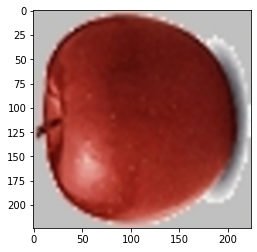

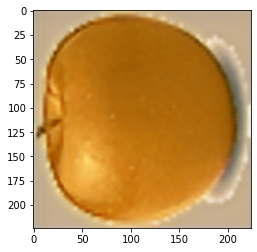

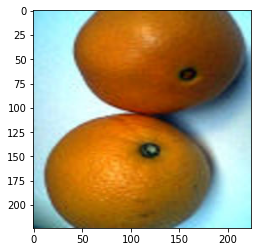

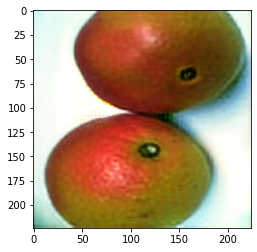

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.76101294966305 | dloss : 0.9587170162621667
weight saved!!


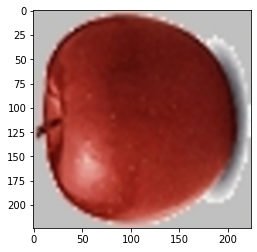

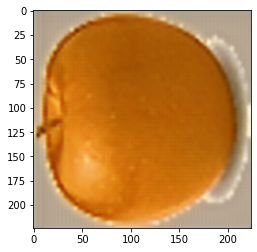

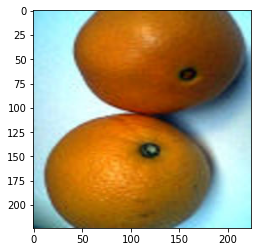

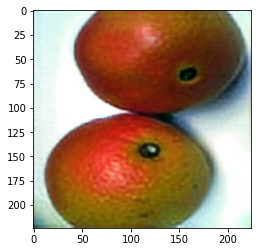

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.716438076542873 | dloss : 0.9285830251142091
weight saved!!


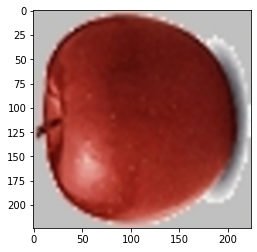

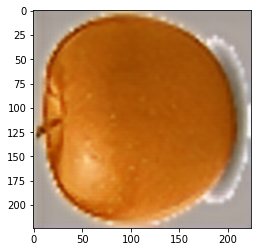

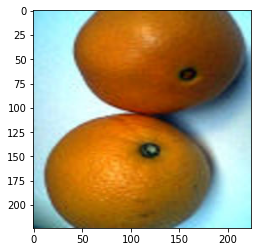

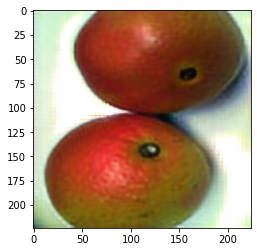

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.687294363975525 | dloss : 0.9372600347388025
weight saved!!


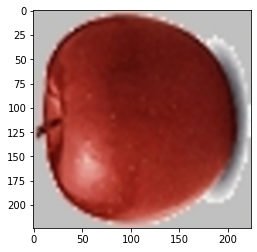

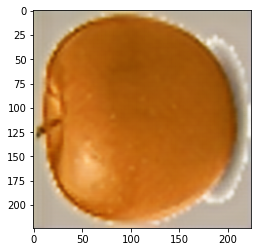

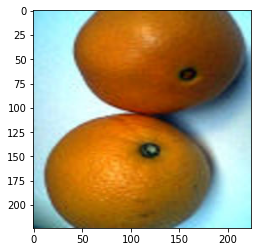

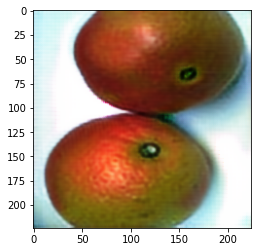

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6978527293485755 | dloss : 0.9505380396749459
weight saved!!


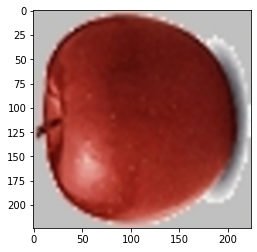

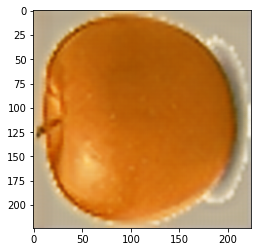

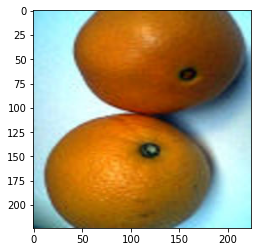

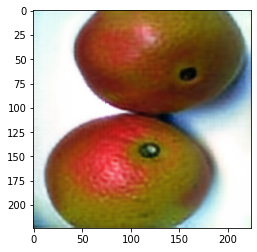

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6899797818239997 | dloss : 0.939017244647531
weight saved!!


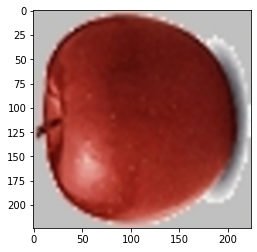

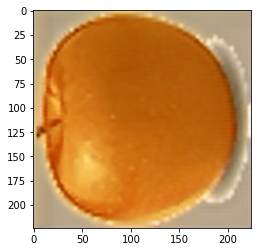

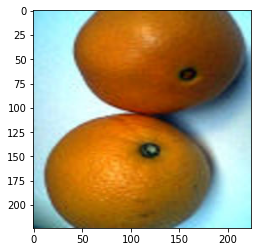

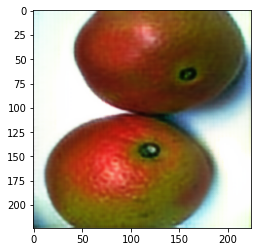

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6720143266752654 | dloss : 0.9468340880730572
weight saved!!


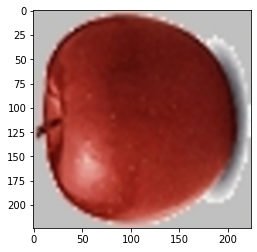

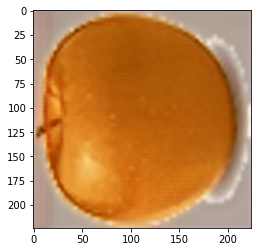

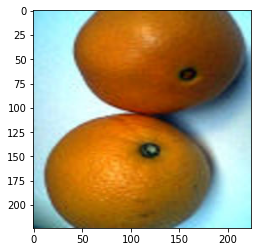

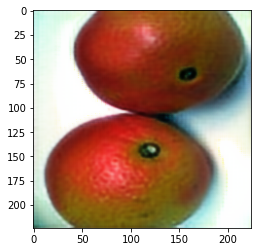

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.638832657477435 | dloss : 0.9487807680578793
weight saved!!


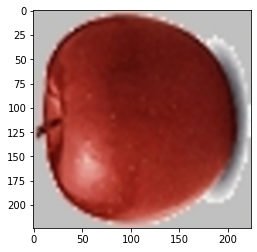

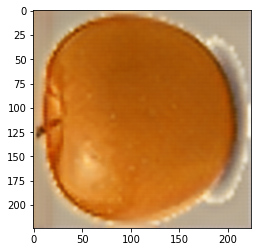

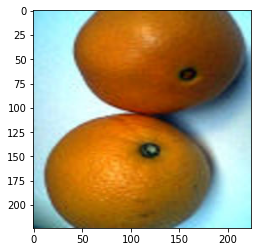

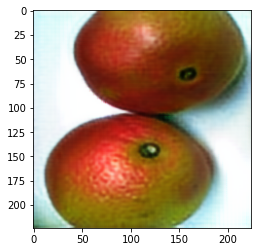

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.674044857305639 | dloss : 0.9571590291518791
weight saved!!


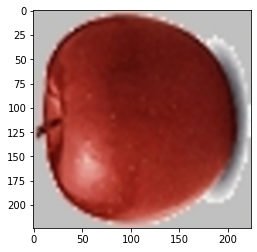

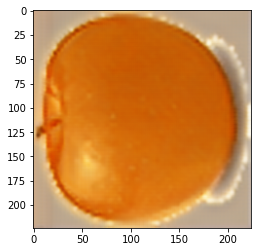

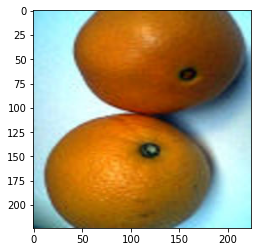

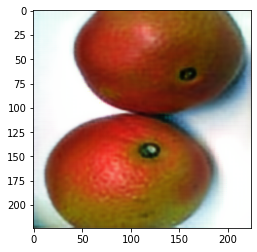

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6567480283624985 | dloss : 0.9512234836232428
weight saved!!


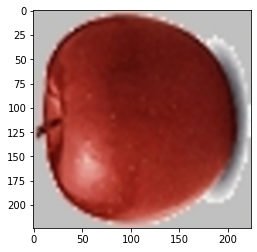

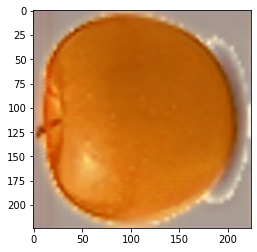

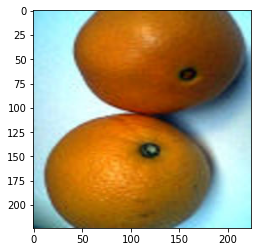

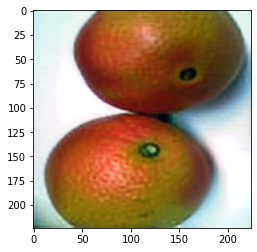

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6253062037860646 | dloss : 0.9479337952884973
weight saved!!


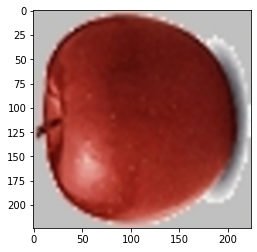

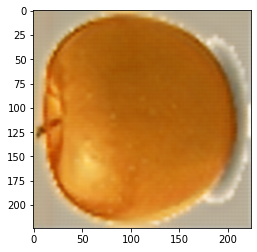

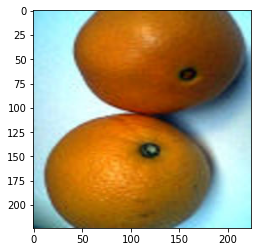

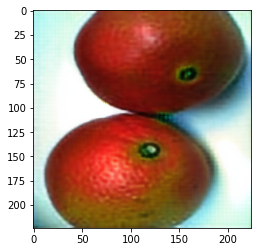

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.65953301635443 | dloss : 0.9439704457918803
weight saved!!


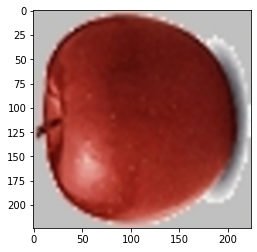

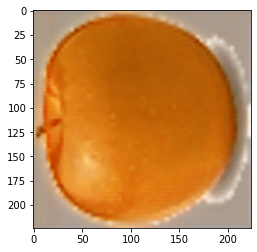

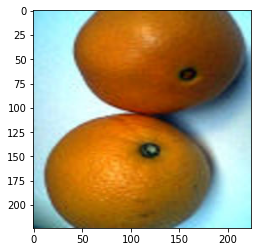

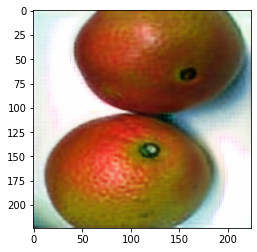

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6082921547048232 | dloss : 0.9484631229849423
weight saved!!


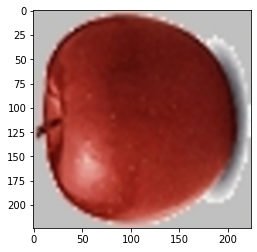

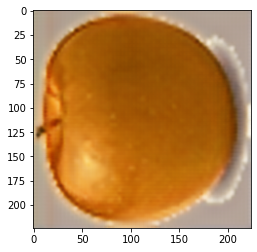

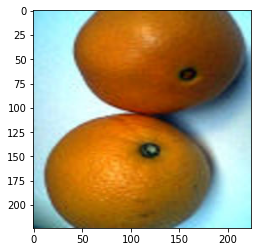

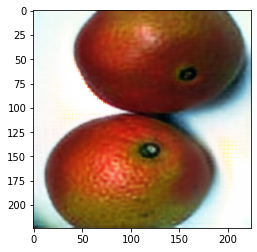

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.5889573779760622 | dloss : 0.9520948403021868
weight saved!!


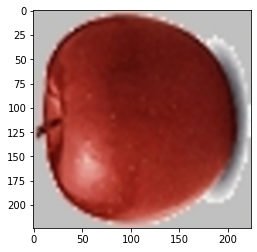

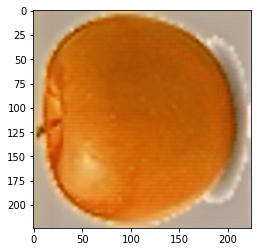

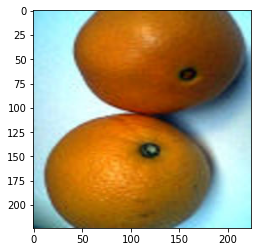

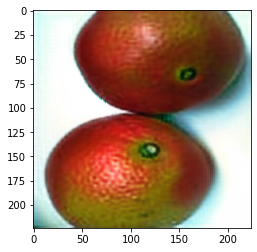

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.5988264163335164 | dloss : 0.9528217434883117
weight saved!!


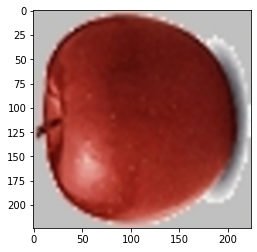

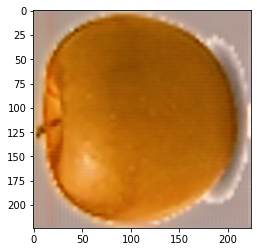

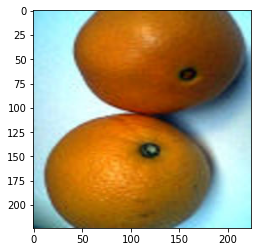

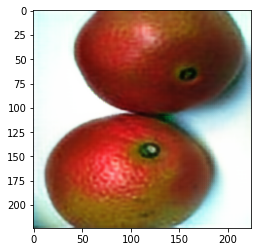

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.5831512266514347 | dloss : 0.9456392410923453
weight saved!!


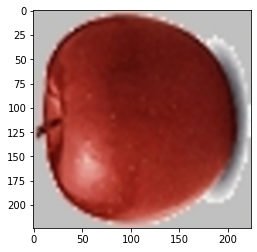

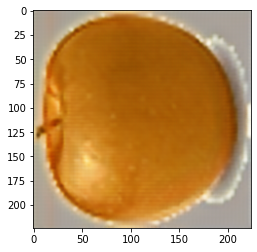

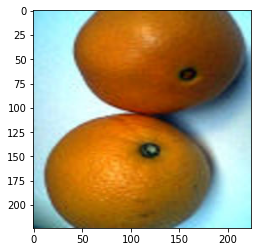

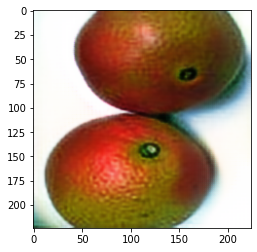

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.5836763564278098 | dloss : 0.9449768865809721
weight saved!!


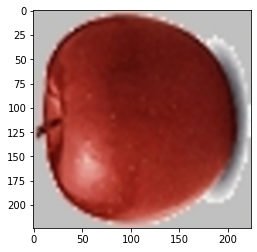

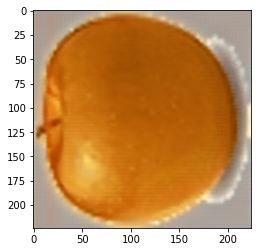

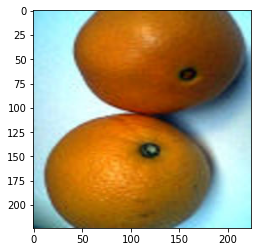

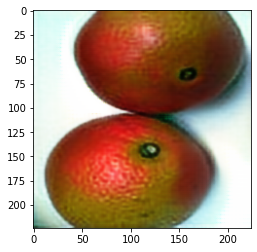

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6025974530799716 | dloss : 0.9365844347897698
weight saved!!


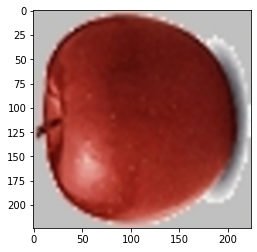

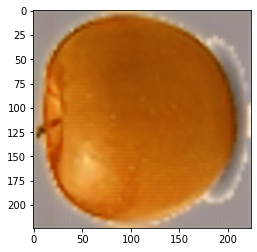

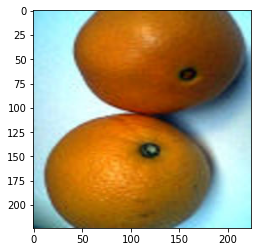

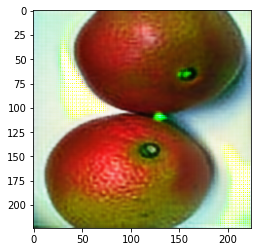

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.6027960220972697 | dloss : 0.9321073509898841
weight saved!!


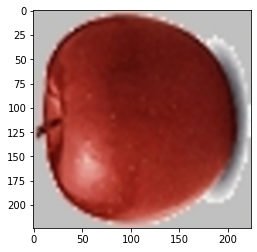

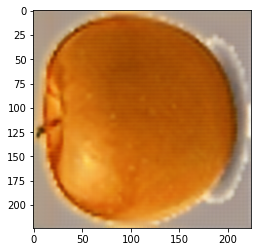

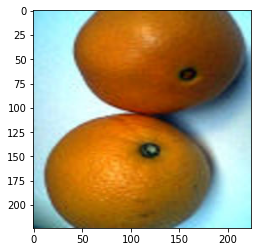

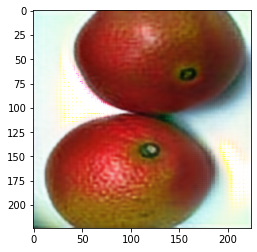

  0%|          | 0/255 [00:00<?, ?it/s]

gloss : 1.5772614684759403 | dloss : 0.9504177416072173
weight saved!!


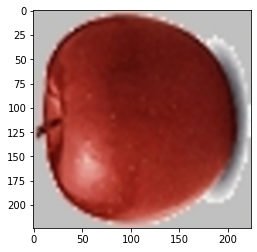

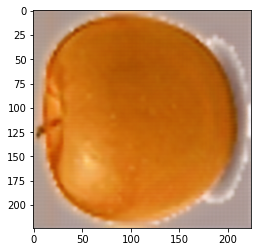

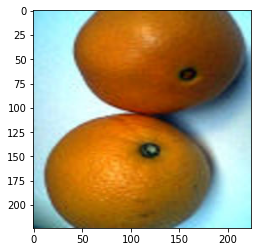

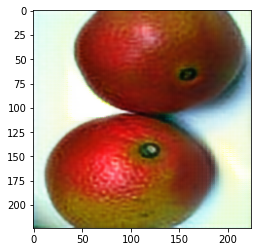

In [12]:
for i in range(20):
    trainer.fit(dataloader, test_dataloader)
    trainer.test(test_dataloader)